# Introduction to Machine Learning with Football Players

This notebook is an introduction to machine learning applied on [this](https://github.com/loistal/ADA_labs/blob/master/04%20-%20Applied%20ML/DATA.md) dataset.

The goal is to be able to predict the skin color of a player, using supervised and unsupervised techniques.

## Data Pre-Processing

First, we need to work on the data to clean it and get it ready for the learning part.

We use [this](http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb) notebook to help us achieving this task.

In [29]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn as sk

# Display plots inline
%matplotlib inline 

### First Look
Let's import the data and take a look at it : 

In [30]:
filename = 'CrowdstormingDataJuly1st.csv'

# Create dataframe from the CSV file
df = pd.read_csv(filename)

print('Shape : {}.'.format(df.shape))
df.head(5)

Shape : (146028, 28).


,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


As explained in the data description, each row of the dataset is a dyad, which means that each row represents data for a given player under a given referee, with additional data about the player and the referee themselves.

### Skin information
From the `rater2` column above, some values are missing, which means there is no pictures. Given we base our analysis on the skin color, the row without picture or raters don't contain any information about the skin color, we choose to drop them.

In [31]:
print('{} % of the pictures are missing.'.format(df.photoID.isnull().sum() / len(df.photoID)))

# Drop the null rows
df = df[df.photoID.notnull()]

df.head(5)

0.14659517352836443 % of the pictures are missing.


,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,1.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


### Player - Referee interaction analysis
Let's look at some attributes in more detail to improve our understanding of the player-referee interactions.

** How many times does a player meet the same referee ? **

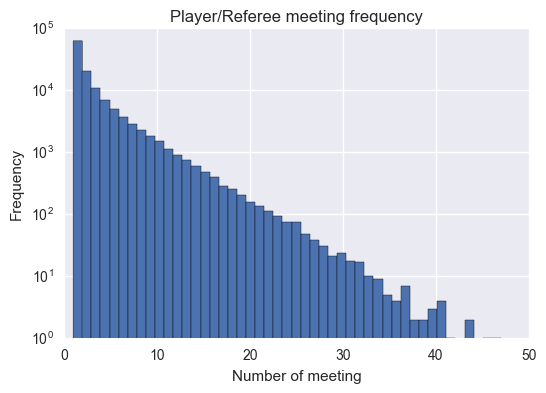

In [32]:
fig, ax = plt.subplots()
ax.hist(df.games, bins=max(df.games))
ax.set_title('Player/Referee meeting frequency')
ax.set_xlabel('Number of meeting')
ax.set_ylabel('Frequency')
ax.set_yscale('log')
plt.show()

As we can see, most of the time, a player and a referee meet only once. 

**In how many diads does a referee appear ?**

Total number of referees : 2978.


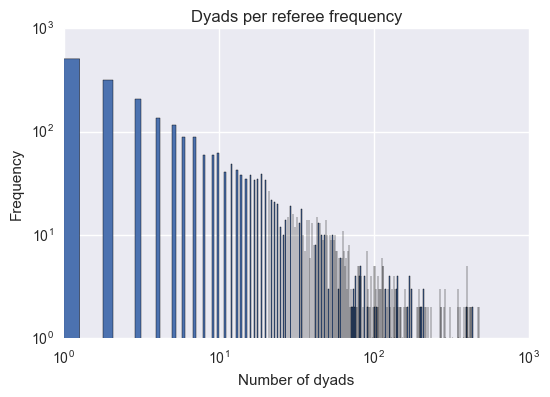

In [33]:
ref_freq = df['refNum'].value_counts()

print('Total number of referees : {}.'.format(len(ref_freq)))

fig, ax = plt.subplots()
ax.hist(list(ref_freq), bins=len(ref_freq))
ax.set_title('Dyads per referee frequency')
ax.set_xlabel('Number of dyads')
ax.set_xscale('log')
ax.set_ylabel('Frequency')
ax.set_yscale('log')
plt.show()

We can see here that most of the referee appear in a very small number of dyads. This is problematic, because for one single game, a referee should appear at least 22 times, because there are 22 players on the field.

The problem (discovered [here](http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb)) comes actually from the fact that all the history the data contains all the history of each player. This can explain why we get some weird data for referees.

To fix this problem, we need to remove each row which corresponds to a referee which appears in less that 22 dyads : 

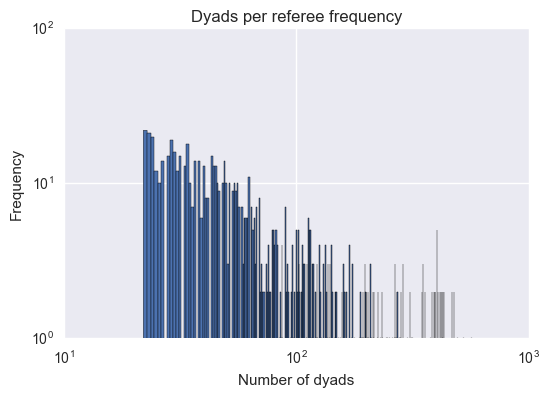

In [34]:
# Get all the valid referee IDs 
valid_ref = list(ref_freq[ref_freq > 21].index)

# Filter the dataframe
df = df[df['refNum'].isin(valid_ref)]

ref_freq = df['refNum'].value_counts()

# Plot again the frequency
fig, ax = plt.subplots()
ax.hist(ref_freq, bins=len(ref_freq))
ax.set_title('Dyads per referee frequency')
ax.set_xlabel('Number of dyads')
ax.set_xscale('log')
ax.set_ylabel('Frequency')
ax.set_yscale('log')
plt.show()

This looks way better.

### Quantifying Racism
It seems that the data doesn't contain any major impurity now, but we are not ready yet. 

We don't lose our final goal which is predicting skin color for players, but for now we only have dyads. We need to find a way to extract information about players only.

We could actually just ignore the referee information for each dyads and then aggregate the information for each player. The problem with this solution is that we would lose all information about racism, which seems to be (unfortunately) the only useful source of information related to the skin color. We then have to find a way to extract the racism information from the referee and associate it to the player. 

We will define a new attribute, called `racismScore`, which associate with each player, the "amount of racism that he potentially received from referees". We will compute this score with the `meanIAT`, `meanExp`, yellow and red cards. 

To find out a formula that makes sense, we first take a look at these values : 

There are 110 NaN IAT values and 110 NaN Exp values.


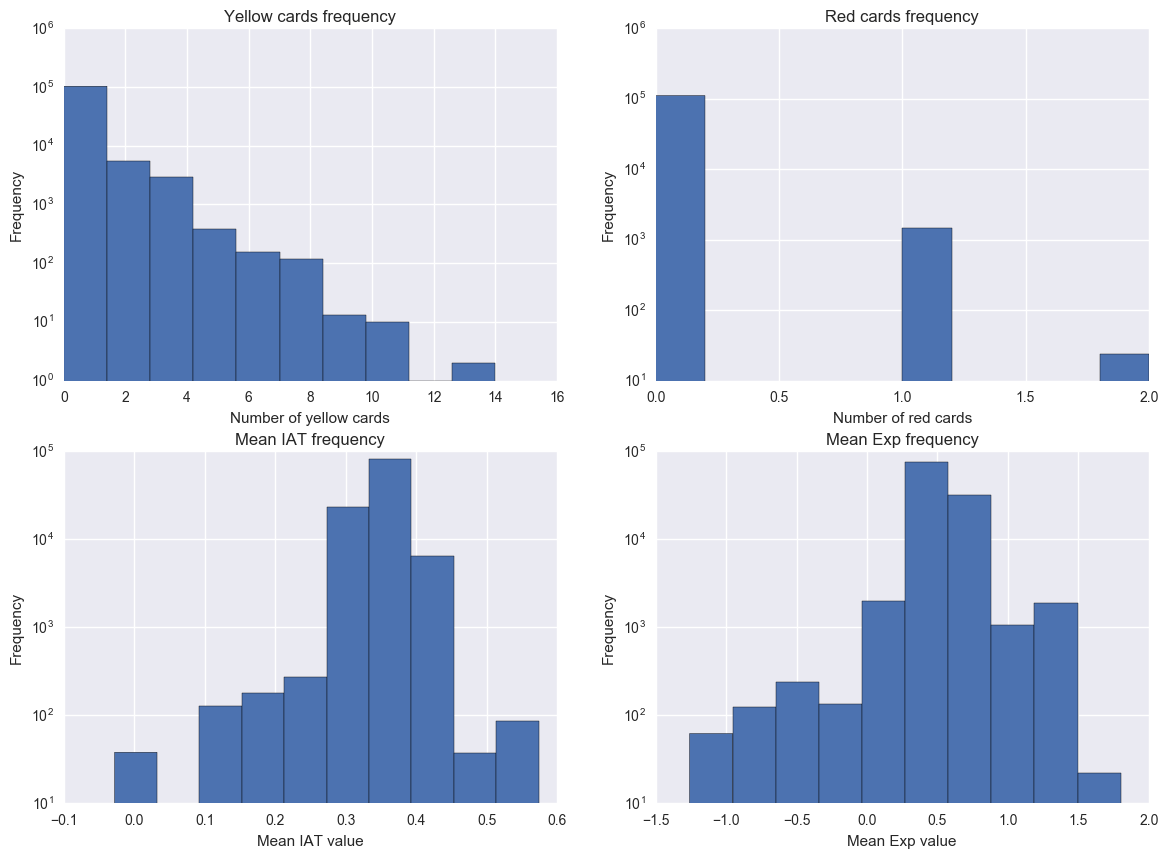

In [35]:
print('There are {} NaN IAT values and {} NaN Exp values.'.format(df['meanIAT'].isnull().sum(), df['meanExp'].isnull().sum()))
iat = df['meanIAT'].dropna()
exp = df['meanExp'].dropna()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

ax1.hist(df['yellowCards'])
ax1.set_title('Yellow cards frequency')
ax1.set_yscale('log')
ax1.set_xlabel('Number of yellow cards')
ax1.set_ylabel('Frequency')

ax2.hist(df['redCards'])
ax2.set_title('Red cards frequency')
ax2.set_yscale('log')
ax2.set_xlabel('Number of red cards')
ax2.set_ylabel('Frequency')

ax3.set_title('Mean IAT frequency')
ax3.hist(iat)
ax3.set_yscale('log')
ax3.set_xlabel('Mean IAT value')
ax3.set_ylabel('Frequency')

ax4.set_title('Mean Exp frequency')
ax4.hist(exp)
ax4.set_yscale('log')
ax4.set_xlabel('Mean Exp value')
ax4.set_ylabel('Frequency')

plt.show()

As we can see, most of the cards are yellow, and there are some rare red cards. 

We need to normalize the IAT and Exp values in order to make the count equally in our calculations. We also need to get rid of the NaN values :

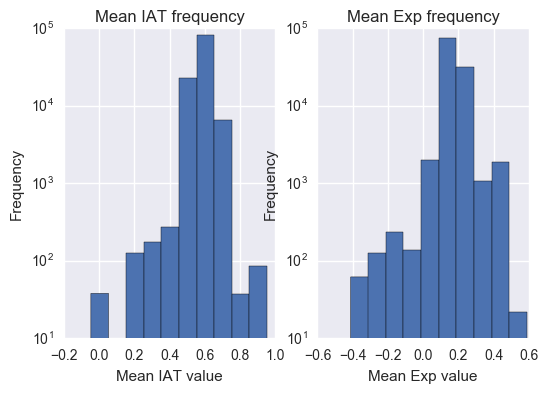

In [36]:
# Get rid of NaN values
df = df[df['meanIAT'].notnull()]
df = df[df['meanExp'].notnull()]

# Normalize the IAT and Exp values
df['meanIAT'] = (df['meanIAT'] / (max(df['meanIAT']) - min(df['meanIAT'])))
df['meanExp'] = (df['meanExp'] / (max(df['meanExp']) - min(df['meanExp'])))

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_title('Mean IAT frequency')
ax1.hist(df['meanIAT'])
ax1.set_yscale('log')
ax1.set_xlabel('Mean IAT value')
ax1.set_ylabel('Frequency')

ax2.set_title('Mean Exp frequency')
ax2.hist(df['meanExp'])
ax2.set_yscale('log')
ax2.set_xlabel('Mean Exp value')
ax2.set_ylabel('Frequency')

plt.show()


We can now define our new `racismScore attribute` : 
$$racismScore = (yellowCard + redCard) \times (newIAT + newExp) / 2 $$
where $newIAT = meanIAT - min(meanIAT) + 1$ and $newExp = meanExp - min(meanExp) + 1$ in order to not modify the number of cards when the IAT and Exp values are minimum.

In [37]:
# Define the new feature
newIAT = df['meanIAT'] - min(df['meanIAT']) + 1
newExp = df['meanExp'] - min(df['meanExp']) + 1
df['racismScore'] = (df['yellowCards'] + df['redCards']) * (newIAT + newExp) / 2

# Drop cards related ones to not count them twice
df = df.drop(['yellowCards', 'redCards', 'yellowReds'], axis = 1)

### Extracting Player Descriptions
Now that we have a way to caracterize racism, we want to drop referee information and aggregate rows by player to get individual player descriptions. We also consider the problem as binary, which means we want to find the skin color as a binary value light or dark : 

In [38]:
# Drop referee informations
df = df.drop(['refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp'], axis = 1)

# Define the functions used to aggregate data 
funcs = {'games': sum, 'victories': sum, 'ties': sum, 'defeats': sum, 'goals': sum, 
         'rater1': np.mean, 'rater2': np.mean, 'racismScore': np.mean}

# Aggregate player attributes
groupby_cols = ['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height', 'weight', 'position', 'photoID']
df = df.groupby(groupby_cols).agg(funcs).reset_index()

# Average the raters
df['skinColor'] = (df['rater1'] + df['rater2']) / 2
df = df.drop(['rater1', 'rater2'], axis = 1)
df['skinColor'] = df['skinColor'].apply(lambda x : 0 if x < 0.5 else 1)

df.head(5)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,photoID,defeats,goals,ties,racismScore,victories,games,skinColor
0,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,3868.jpg,221,8,174,0.200209,240,635,0
1,aaron-hunt,Aaron Hunt,Werder Bremen,Germany,04.09.1986,183.0,73.0,Attacking Midfielder,20136.jpg,119,59,70,0.671219,139,328,0
2,aaron-lennon,Aaron Lennon,Tottenham Hotspur,England,16.04.1987,165.0,63.0,Right Midfielder,13515.jpg,115,31,96,0.172768,200,411,0
3,aaron-ramsey,Aaron Ramsey,Arsenal FC,England,26.12.1990,178.0,76.0,Center Midfielder,94953.jpg,67,39,42,0.520935,144,253,0
4,abdelhamid-el-kaoutari,Abdelhamid El-Kaoutari,Montpellier HSC,France,17.03.1990,180.0,73.0,Center Back,124913.jpg,43,1,40,0.422175,41,124,0


### Categorical Data Encoding

It turns out our data is not totally ready yet... Actually `scikit-learn` can't handle categorical data as strings, so we need to encode our categorical features in a good way. We will use dummy variables and the pandas function `get_dummies` to achieve this task.

But first, we observe that some of the categorical features are unique for each player, like the name, photo ID, or birthday, we can safely remove than, as they don't add any information : 

In [39]:
df = df.drop(['playerShort', 'player', 'birthday', 'photoID'], axis=1)

Now, we can encode our useful categorical data with dummies : 

In [40]:
# Convert categorical data to dummy variables
df = pd.get_dummies(df, columns=['club', 'leagueCountry', 'position'])

df.head(5)

,height,weight,defeats,goals,ties,racismScore,victories,games,skinColor,club_1. FC Nürnberg,...,position_Center Forward,position_Center Midfielder,position_Defensive Midfielder,position_Goalkeeper,position_Left Fullback,position_Left Midfielder,position_Left Winger,position_Right Fullback,position_Right Midfielder,position_Right Winger
0,182.0,71.0,221,8,174,0.200209,240,635,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,183.0,73.0,119,59,70,0.671219,139,328,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,165.0,63.0,115,31,96,0.172768,200,411,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,178.0,76.0,67,39,42,0.520935,144,253,0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,180.0,73.0,43,1,40,0.422175,41,124,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Congratulations**, we are now ready to start to grow some trees and forests!

## Supervised Machine Learning

The goal of this part is to be able to predict a player skin color with a `RandomForestClassifer` model using `scikit-learn`.

We first a naive `RandomForestClassifier`, by training and testing the model on the same data : 

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Define the data and the labels
dataset = df.drop(['skinColor'], axis = 1)
labels = df['skinColor']

# Instantiate the model
rfc = RandomForestClassifier()

# Fit with the data
rfc.fit(dataset, labels)

# Test the model
y_pred = rfc.predict(dataset)

print('Accuracy for raw model : {} %.'.format(metrics.accuracy_score(labels, y_pred) * 100))

Accuracy for raw model : 98.23695345557122 %.


As we can see, it seems really accurate, this is due to overfitting, let's play with the `RandomForestClassifier` parameters (we choose to not use the `GridSearchCV` class, given it uses cross-validation, and we are not interested in cross-validation for now): 

In [42]:
# Define parameters for the model
max_features = ['sqrt', 'log2', None]
max_depth = [10, 100, 1000]
min_samples_split = [2, 4, 6]

for i in max_features:
    for j in max_depth:
        for k in min_samples_split:
            print('max_feature : {}, max_depth : {}, min_samples_split : {}.'.format(i, j, k))
            
            rfc = RandomForestClassifier(max_features=i, max_depth=j, min_samples_split=k)
            rfc.fit(dataset, labels)
            y_pred = rfc.predict(dataset)

            print('--- Accuracy : {} %.'.format(metrics.accuracy_score(labels, y_pred) * 100))
         

max_feature : sqrt, max_depth : 10, min_samples_split : 2.
--- Accuracy : 82.36953455571228 %.
max_feature : sqrt, max_depth : 10, min_samples_split : 4.
--- Accuracy : 81.24118476727786 %.
max_feature : sqrt, max_depth : 10, min_samples_split : 6.
--- Accuracy : 81.5937940761636 %.
max_feature : sqrt, max_depth : 100, min_samples_split : 2.
--- Accuracy : 97.24964739069112 %.
max_feature : sqrt, max_depth : 100, min_samples_split : 4.
--- Accuracy : 95.27503526093088 %.
max_feature : sqrt, max_depth : 100, min_samples_split : 6.
--- Accuracy : 93.44146685472496 %.
max_feature : sqrt, max_depth : 1000, min_samples_split : 2.
--- Accuracy : 97.53173483779972 %.
max_feature : sqrt, max_depth : 1000, min_samples_split : 4.
--- Accuracy : 96.262341325811 %.
max_feature : sqrt, max_depth : 1000, min_samples_split : 6.
--- Accuracy : 93.65303244005642 %.
max_feature : log2, max_depth : 10, min_samples_split : 2.
--- Accuracy : 80.25387870239774 %.
max_feature : log2, max_depth : 10, min_samp

We can mainly see that overfitting is limited by the maximum depth of the tree.

Let's perform cross-validation in order to limit more carefully overfitting : 

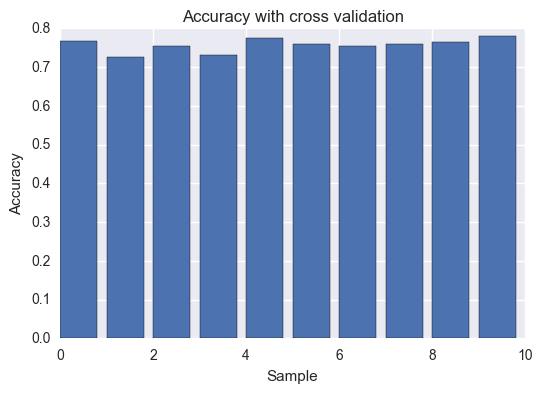

In [43]:
from sklearn.cross_validation import cross_val_score

rfc = RandomForestClassifier()

# Perform the cross validation with 10 different combinations
acc = cross_val_score(rfc, dataset, labels, cv=10, scoring='accuracy')

fig, ax = plt.subplots()

ax.bar(left=np.arange(10), height=acc)
ax.set_title('Accuracy with cross validation')
ax.set_xlabel('Sample')
ax.set_ylabel('Accuracy')

plt.show()

That seems quite satisfying.

**What are the most important features ?**

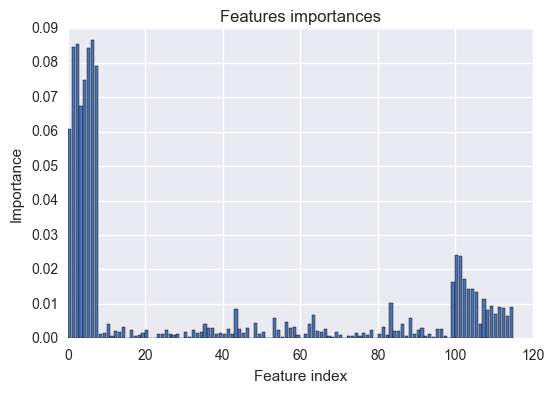

In [44]:
# Instantiate the model
rfc = RandomForestClassifier()

# Fit with the data
rfc.fit(dataset, labels)

fig, ax = plt.subplots()
ax.bar(left=np.arange(len(rfc.feature_importances_)), height=rfc.feature_importances_)
ax.set_title('Features importances')
ax.set_xlabel('Feature index')
ax.set_ylabel('Importance')
plt.show()

Clearly, the most important features are the first 8, let's take a closer look : 

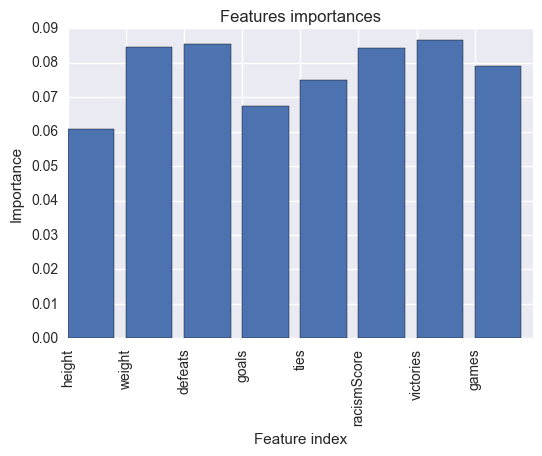

In [46]:
importances = rfc.feature_importances_[:8]
names = list(df.columns[:8])

fig, ax = plt.subplots()
ax.bar(left=np.arange(len(importances)), height=importances)
ax.set_title('Features importances')
ax.set_xlabel('Feature index')
ax.set_ylabel('Importance')
ax.set_xticklabels(names, rotation='vertical', ha='center')
ax.set_xticks(np.arange(len(importances)))
plt.show()

It's not surprising to see that the most useful features are the ones about the players stats, and not the club, country etc...

## Unsupervised Machine Learning